# Palmer Penguins Modeling

Import the Palmer Penguins dataset and print out the first few rows.

Suppose we want to predict `bill_depth_mm` using the other variables in the dataset.

**Dummify** all variables that require this.

In [ ]:
%pip install palmerpenguins

In [ ]:
# Code Here
%echo
import pandas as pd
import numpy as np
from palmerpenguins import load_penguins
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt


In [ ]:
penguins = load_penguins()

In [ ]:
penguins.isnull().sum()

,0
species,0
island,0
bill_length_mm,2
bill_depth_mm,2
flipper_length_mm,2
body_mass_g,2
sex,11
year,0


In [ ]:
categoricals = ["species", "island", "sex"]

penguins = pd.get_dummies(penguins, columns=categoricals, drop_first=True)
penguins.head()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,year,species_Chinstrap,species_Gentoo,island_Dream,island_Torgersen,sex_male
0,39.1,18.7,181.0,3750.0,2007,False,False,False,True,True
1,39.5,17.4,186.0,3800.0,2007,False,False,False,True,False
2,40.3,18.0,195.0,3250.0,2007,False,False,False,True,False
3,NaN,NaN,NaN,NaN,2007,False,False,False,True,False
4,36.7,19.3,193.0,3450.0,2007,False,False,False,True,False


In [ ]:
penguins.dropna(inplace=True)

Let's use the other variables to predict `bill_depth_mm`. Prepare your data and fit the following models on the entire dataset:

* Your best multiple linear regression model from before (using all predictors)
* Two kNN models (for different values of K)
* A decision tree model

Create a plot like the right plot of Fig 1. in our `Model Validation` chapter with the training and test error plotted for each of your four models.

Which of your models was best?

In [ ]:
# split data into train and tes
X = penguins.drop(columns=["bill_depth_mm"])
y = penguins["bill_depth_mm"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# model 1: fit on all predictors, will later compare to the other models
lr = LinearRegression()
lr.fit(X_train, y_train)


LinearRegression()

In [ ]:
# model 2: two different knn for diff values for k (maybe use grid search?)

param_grid = {"n_neighbors": list(range(1, 31))}
knn = KNeighborsRegressor()

grid = GridSearchCV(knn, param_grid, scoring="neg_root_mean_squared_error", cv=5)
grid.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30]},
             scoring='neg_root_mean_squared_error')

In [ ]:
grid.best_params_["n_neighbors"]


6

In [ ]:
-grid.best_score_

np.float64(1.4919475874343833)

In [ ]:
cv_results = pd.DataFrame(grid.cv_results_)
cv_results["RMSE"] = -cv_results["mean_test_score"]
cv_results = cv_results.sort_values("RMSE")
K1 = cv_results.iloc[0]["param_n_neighbors"]
K2 = cv_results.iloc[1]["param_n_neighbors"]
print(K1, "and", K2)

6 and 7


In [ ]:
knn1 = KNeighborsRegressor(n_neighbors=int(K1))
knn2 = KNeighborsRegressor(n_neighbors=int(K2))

knn1.fit(X_train, y_train)
knn2.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=7)

In [ ]:
# model 3
tree = DecisionTreeRegressor(random_state=0)
tree.fit(X_train, y_train)

DecisionTreeRegressor(random_state=0)

In [ ]:
models = {
    "Linear Regression": lr,
    f"kNN (K={int(K1)})": knn1,
    f"kNN (K={int(K2)})": knn2,
    "Decision Tree": tree
}

results = []
for name, model in models.items():
    y_pred_train = model.predict(X_train)
    y_pred_test  = model.predict(X_test)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    test_rmse  = np.sqrt(mean_squared_error(y_test,  y_pred_test))
    results.append({"Model": name, "Train RMSE": train_rmse, "Test RMSE": test_rmse})

df_results = pd.DataFrame(results)
df_results


,Model,Train RMSE,Test RMSE
0,Linear Regression,0.789856,0.745515
1,kNN (K=6),1.297635,1.536305
2,kNN (K=7),1.303162,1.533508
3,Decision Tree,0.000000,1.017029


decision tree is overfitting, k=7 knn is probably underfitting

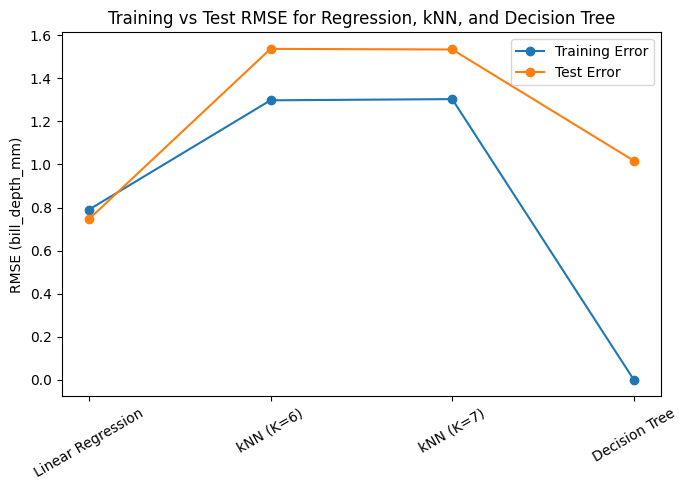

In [ ]:
plt.figure(figsize=(7,5))
plt.plot(df_results["Model"], df_results["Train RMSE"], marker="o", label="Training Error")
plt.plot(df_results["Model"], df_results["Test RMSE"], marker="o", label="Test Error")
plt.title("Training vs Test RMSE for Regression, kNN, and Decision Tree")
plt.ylabel("RMSE (bill_depth_mm)")
plt.xticks(rotation=30)
plt.legend()
plt.tight_layout()
plt.show()

The multiple linear regression model achieved the lowest test RMSE and nearly equal training error, indicating the best generalization performance.
Both kNN models, with K = 6 and 7, produced higher errors, suggesting mild underfitting, while the decision tree severely overfit the training data (zero training error but much higher test error).
Therefore, the linear regression model was the best overall for predicting `bill_depth_mm`.